# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

**Задача**: построить модель, которая по фотографии определит приблизительный возраст человека. В моем распоряжении набор фотографий людей с указанием возраста.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

## Исследовательский анализ данных

Загружу датасет

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


В колонке `'file_name'` название изображения, в `'real_age'` - возраст человека на изображении

In [8]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Всего 7591 изображение. Посмотрю распределение возрастов

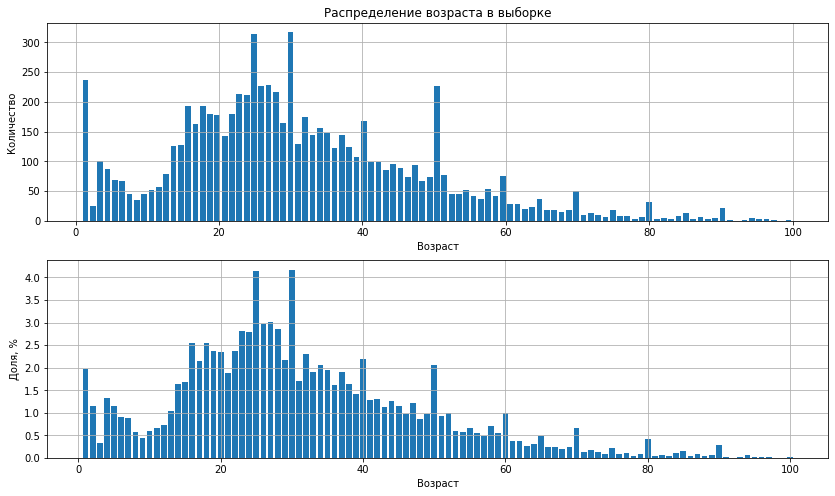

In [4]:
plt.figure(figsize=(14, 8))
plt.subplot(2,1,1)
labels['real_age'].hist(bins=labels['real_age'].value_counts(normalize=True).shape[0], width=0.8)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')

plt.subplot(2,1,2)
plt.bar(labels['real_age'].value_counts(normalize=True).index, 
        labels['real_age'].value_counts(normalize=True)*100)
plt.xlabel('Возраст')
plt.ylabel('Доля, %')
plt.grid();

In [5]:
labels['real_age'].value_counts().describe()

count     97.000000
mean      78.257732
std       74.559579
min        1.000000
25%       15.000000
50%       54.000000
75%      128.000000
max      317.000000
Name: real_age, dtype: float64

In [6]:
labels['real_age'].value_counts().tail(10)

78     3
81     3
83     3
88     3
95     2
96     2
93     1
100    1
91     1
97     1
Name: real_age, dtype: int64

Посмотрю 10 случайных изображений

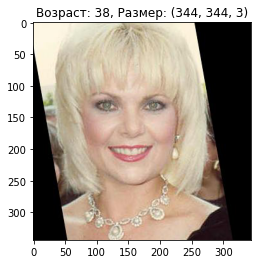

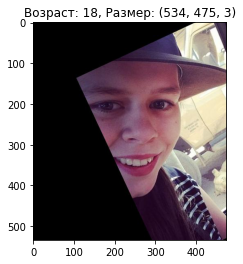

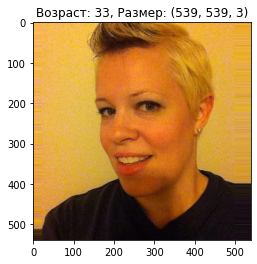

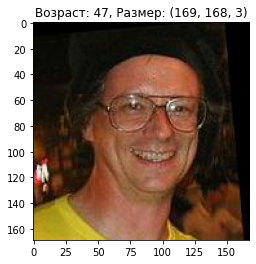

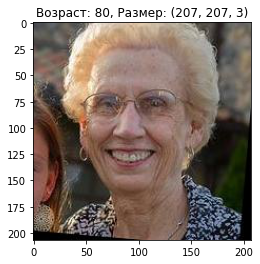

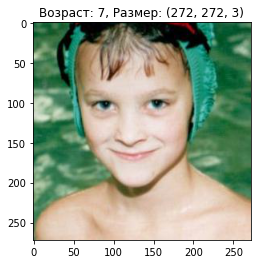

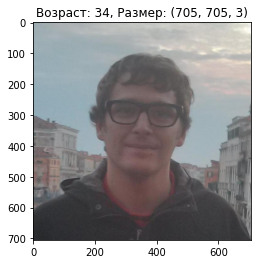

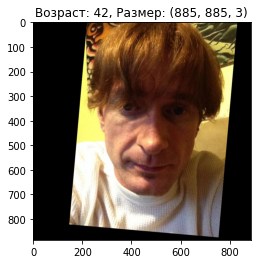

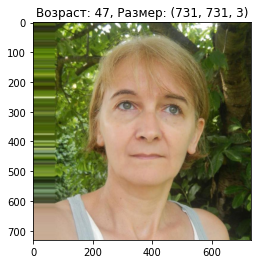

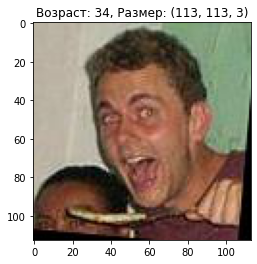

In [7]:
for i in np.random.randint(0, labels.shape[0], size=10):
    image_name = labels.loc[i, 'file_name']
    plt.figure()
    array = np.array(Image.open(f'/datasets/faces/final_files/{image_name}'))
    plt.imshow(array)
    plt.title(f'Возраст: {labels.loc[i, "real_age"]}, Размер: {array.shape}')

**Выводы по исследовательскому анализу:**
- имеются изображения людей с возрастом от 1 года до 100 лет
- более 50% картинок людей в возрасте от 10 до 50 лет
- имеются пики на 1, 25, 30, 40, 50, 60, 70, 80 и 90 лет. Это может быть связано с округлением возраста при разметке изображений
- у возрастов 91, 93, 95-97 и 100 меньше трех изображений
- изображения разного размера
- изображения сделаны в весьма широкий временной промежуток
- изображения состоят из 3 слоев - RGB
- изображения имею различную ориентацию
- помимо людей с различной ориентацией лица имеются постороние предметы

## Обучение модели

Определние возраста по изображению - задача регрессии. Для ее решения буду использовать архитектуру ResNet, которая использует дополнительные связи внутри сети, позволяющие избежать проблемы затухающего градиента.
Так как все изображения имеют различный размер, то приведу их к единому - 224х224. Разделю все изображения на обучающую и тестовую выборки в соотношении 3:1, применив к обеим нормализацию. К изображениям обучающей выборки применю горизонтальное отражение.

Применю предобученную на ImageNet сеть - то есть веса будут инициализированы на огромном 1000классовам датасете ImageNet. Последние два слоя: GlobalAveragePooling2D (среднее значение из группы пикселей внутри канала) и Dense(один нейрон и функция активация ReLu). Функция потерь - MSE, алгоритм обучения - Adam, метрика качества - MAE, количество эпох - 10.

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                 validation_split=0.25,
                                 horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                           directory=path +'final_files/',
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='raw',
                                           subset='training',
                                           seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1. / 255,
                                      validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                           directory=path +'final_files/',
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='raw',
                                           subset='validation',
                                           seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(1, activation='relu')])

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs,
        batch_size=batch_size,
        steps_per_epoch=train_data,
        validation_steps=validation_steps,
        verbose=2)
   
    return model

```

Результат модели

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-08-06 16:20:24.793170: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-06 16:20:25.175905: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 54s - loss: 225.9422 - mae: 10.8262 - val_loss: 734.9429 - val_mae: 22.1818
Epoch 2/10
178/178 - 43s - loss: 75.2952 - mae: 6.5597 - val_loss: 740.2657 - val_mae: 22.2209
Epoch 3/10
178/178 - 44s - loss: 49.0527 - mae: 5.3368 - val_loss: 238.8047 - val_mae: 11.5334
Epoch 4/10
178/178 - 43s - loss: 36.4692 - mae: 4.5733 - val_loss: 109.3756 - val_mae: 7.9170
Epoch 5/10
178/178 - 44s - loss: 27.9203 - mae: 4.0425 - val_loss: 75.5888 - val_mae: 6.6070
Epoch 6/10
178/178 - 43s - loss: 21.1358 - mae: 3.5121 - val_loss: 82.4049 - val_mae: 6.7408
Epoch 7/10
178/178 - 43s - loss: 16.9008 - mae: 3.1513 - val_loss: 63.5494 - val_mae: 5.9682
Epoch 8/10
178/178 - 39s - loss: 14.0481 - mae: 2.8683 - val_loss: 70.6249 - val_mae: 6.3655
Epoch 9/10
178/178 - 39s - loss: 11.9367 - mae: 2.6167 - val_loss: 60.9407 - val_mae: 5.8425
Epoch 10/10
178/178 - 40s - loss: 11.1021 - mae: 2.5050 - val_loss: 62.6207 - val_mae: 5.8400
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 62.6207 - mae: 5.8400
Test MAE: 5.8400
```

## Анализ обученной модели

Обученная модель смогла определить возраст человека по фотографии с точностью +/- 5.84 года, что соответствует требуемой точности менее 8 лет.

С каждой эпохой MAE уменьшается как на обучающей, так и на тестовой выборках. Разница метрик двух выборок на последней эпохе составляет более чем 2 раза, что говорит о некотором переобучении. Его можно несколько снизить, добавив после GlobalAveragePooling2D слоя Dropout-слой, сокращающий количество связанных нейронов с Dense слоем.

5.84 - это много или мало? Решать аналитикам и маркетологам, которые будут заниматься рекомендательной системой товаров. Для детей - много, так как модель может ошибиться величиной в целую жизнь ребенка. Для 13-22-летних - тоже, ведь порог продажи агкоголя четко регламентирован. Чем больше возраст, тем вляние точности нивелируется. 